**GUIA 5**

**Ejercicio 1: Modelo de presa predador Lotka-Volterra**

---



El modelo de Lotka-Volterra describe la dinámica de interacción de dos poblaciones, y esta dado por

$$ u_t =   au - buv + D_1 u_{xx}, $$
$$ v_t = - cv + duv + D_2 v_{xx}. $$

En estas ecuaciones $u(x,t)$ es la densidad de presas, $v(x,t)$ la de predadores, $a$ la tasa de nacimiento de presas, $c$ la tasa de muerte de predadores, $b$ y $d$ son los acoplamientos entre especies, y $D_1$ y $D_2$ sus difusividades.


**a**) Resolvé numéricamente el sistema considerando condiciones de contorno periódicas en el dominio unidimensional $x \in [0,2\pi)$, utilizando un método a elección. Elegí todos los parámetros y definí las condiciones iniciales para $u$ y para $v$. Explicá detalladamente la elección del método, de los parámetros y de las condiciones iniciales. Describí la dinámica del sistema en término de las soluciones obtenidas.

**b**) Utilizando tu modelo numérico mostrá el efecto que tienen los coeficientes de difusión en el modelo. *Ayuda: probá distintos valores de* $D_1$ y $D_2$

In [ ]:
#@title Librerias
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from tqdm import tqdm
from IPython.display import Image

In [ ]:
#@title Funcion Animacion
def animacion(size,matriz,titulo,ejex,ejey,x,dt,tf,duracion):
  step = int(tf/dt)
  Afig, Aax = plt.subplots(figsize=size)
  line, = Aax.plot(x,matriz[0])

  title = Aax.set_title(titulo+', $t=0$')
  Aax.set_xlabel(ejex)
  Aax.set_ylabel(ejey)
  Aax.set_ylim(np.min(matriz),np.max(matriz))
  Aax.set_xlim(np.min(x),np.max(x))

  Frames = np.linspace(0,step-1,duracion*30,dtype=int)

  def update(i):
    frame = Frames[i]
    line.set_ydata(matriz[frame])
    title.set_text(titulo+f', $t={round(frame*dt,3)}$')
    return line, title,

  ani = FuncAnimation(Afig, update, frames=len(Frames), blit=True, repeat=False)

  gif_path = 'titulo.gif'
  ani.save(gif_path,writer=PillowWriter(fps=30))
  plt.close(Afig)
  display(Image(filename=gif_path))

In [ ]:
#@title $\bf a)$ Funciones Evol
def evol(U,K,A,B,D,N,dt):
    # Evoluciona en el tiempo la PDE usando el método pseudoespectral y Runge-Kutta de segundo orden
    u, v = U
    F = [np.fft.rfft(u),np.fft.rfft(v)]
    Fuv = compute_interaction(F,K)

    Ft = F

    for ord in [2,1]:       # RK2 midpoint
        D_scalar   = dt/ord
        F   = [Ft[0] + D_scalar * ( A[0] * F[0] + B[0] * Fuv + D[0] * (-K[0]**2) * F[0] ),
                Ft[1] + D_scalar * ( A[1] * F[1] + B[1] * Fuv + D[1] * (-K[1]**2) * F[1] )]
        F[0][int(N/3):] = 0
        F[1][int(N/3):] = 0
    out = [np.fft.irfft(F[0]), np.fft.irfft(F[1])]
    return out

def compute_interaction(F,K):
    V   =  [np.fft.irfft(F[0]), np.fft.irfft(F[1])]
    out = np.fft.rfft(V[0]*V[1])
    return out



In [ ]:
#@title Integrando
step = 90000
nt = step
dt = 1e-4
nx = 128
dx = 2 * np.pi / (nx - 1)

a = 0.1 #+
b = 1 #-
c = 1 #-
d = 2 #+
D_1 = 0.001 #+
D_2 = 0.001 #+
#D_2 1000 A considerar

A = np.array([a,-b])
B = np.array([-c,d])
D = np.array([D_1,D_2])

x = np.linspace(0,2*np.pi,nx,endpoint=False)
t = np.arange(step)*dt
K = np.array([np.arange(0,nx/2+1),np.arange(0,nx/2+1)])


out = np.array([np.zeros((nx,step)),np.zeros((nx,step))])

u = np.zeros((nx, step))
v = np.zeros((nx, step))


# Gaussian parametros
A_u = 1.0
A_v = 0.2
mu_u = np.pi / 2
mu_v = np.pi
sigma_u = 0.5
sigma_v = 0.5
# Defino funcion gaussiana
def gaussian(x, A, mu, sigma):
    return A * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

# C.I.
u[:, 0] = gaussian(x, A_u, mu_u, sigma_u)
v[:, 0] = gaussian(x, A_v, mu_v, sigma_v)

for i in tqdm(np.arange(step-1)):
    u[:, i+1], v[:, i+1] = evol((u[:, i], v[:, i]), K, A, B, D, nx, dt)

100%|██████████| 89999/89999 [00:15<00:00, 5855.20it/s]


Se utilizara como integrador el metodo pseudo espectral con un RK2 ya que este metodo trabaja, como pide la consigna, con C.C. periodicas.
El criterio de CFL teniendo encuenta solo los terminos difusivos marca que

$$ \Delta t \leq \frac{\Delta x^2}{D_{1,2}}  $$

Por lo que para una eleccion de $ \Delta t = 10^{-4} $, $D_{1,2} = 10^{-2}$, se verifica arriba que se cumple la condicion.

Dada como C.I. 2 gaussianas en $\pi/2$ y $\pi$, se esperaba ver un comportamiento de las presas y predadores tal que las predadores busquen a las presas. Los parametros en todas las integraciones se elegieron tal que se pueda ver una evolucion y que esta no de Nan o todas las pobalciones se extingan. En ese sentido, si $v$ no crecia, se incrementaba $d$, si $u$ crecia muy rapido, se incrementaba $b$.

Ademas, sabiendo que el sistema admite soluciones oscilatorias, en la busqueda de estas se aumento $b$ a mas del doble,  se cambio la C.I. de $v$, osea predadores, al modulo del seno con frecuencia $2\pi$.

In [ ]:
# Solucion oscilatoria
D_osc = 0.001
d_osc = 5
D = np.array([D_osc,D_osc])
B_osc = np.array([-c,d_osc])

dt_osc = 1e-3
step = 200000
nt = step
t_osc = np.arange(step)*dt_osc
tf_osc = t_osc[-1]

u_osc = np.zeros((nx, step))
v_osc = np.zeros((nx, step))

u_osc[:, 0] = 0.5 * gaussian(x, A_u, np.pi, sigma_u)
v_osc[:, 0] = 0.1 * np.abs(np.sin(x))

for i in tqdm(np.arange(step-1)):
    # Pass u and v as a tuple to evol
    u_osc[:, i+1], v_osc[:, i+1] = evol((u_osc[:, i], v_osc[:, i]), K, A, B_osc, D, nx, dt_osc)

100%|██████████| 199999/199999 [00:32<00:00, 6110.41it/s]


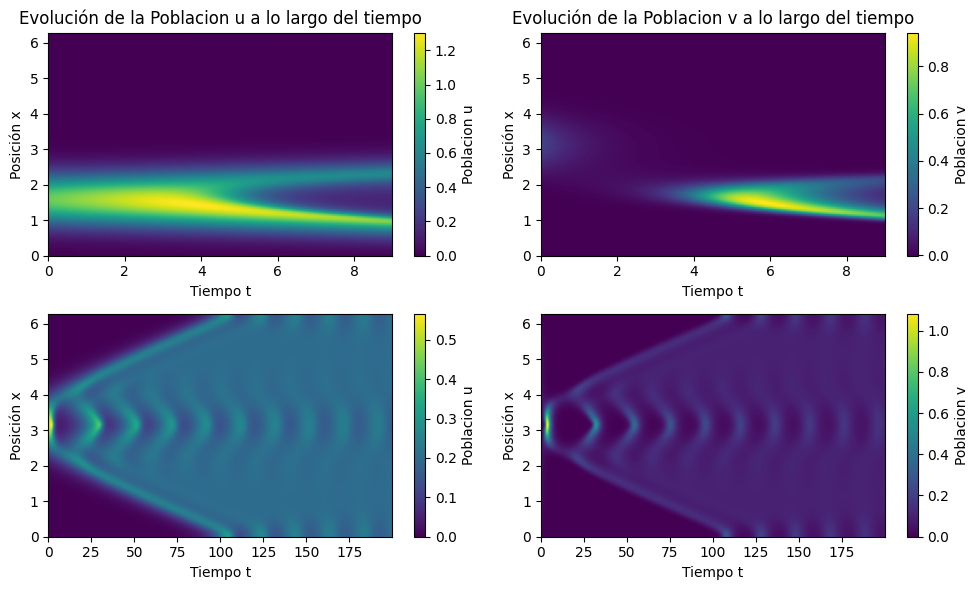

In [ ]:
#@title Imshow
tf = t[-1]
fig, ax = plt.subplots(2, 2, figsize=(10, 6))  # 1 row, 2 columns

# Plot for u
im1 = ax[0,0].imshow(u, cmap='viridis', aspect='auto', extent=[0, tf, 0, 2 * np.pi], origin='lower')
fig.colorbar(im1, ax=ax[0,0], label='Poblacion u')
ax[0,0].set_title('Evolución de la Poblacion u a lo largo del tiempo')
ax[0,0].set_ylabel('Posición x')
ax[0,0].set_xlabel('Tiempo t')


# Plot for v
im2 = ax[0,1].imshow(v, cmap='viridis', aspect='auto', extent=[0, tf, 0, 2 * np.pi], origin='lower')
fig.colorbar(im2, ax=ax[0,1], label='Poblacion v')
ax[0,1].set_title('Evolución de la Poblacion v a lo largo del tiempo')
ax[0,1].set_ylabel('Posición x')
ax[0,1].set_xlabel('Tiempo t')

# Plot for u
im1 = ax[1,0].imshow(u_osc, cmap='viridis', aspect='auto', extent=[0, tf_osc, 0, 2 * np.pi], origin='lower')
fig.colorbar(im1, ax=ax[1,0], label='Poblacion u')
ax[1,0].set_ylabel('Posición x')
ax[1,0].set_xlabel('Tiempo t')


# Plot for v
im2 = ax[1,1].imshow(v_osc, cmap='viridis', aspect='auto', extent=[0, tf_osc, 0, 2 * np.pi], origin='lower')
fig.colorbar(im2, ax=ax[1,1], label='Poblacion v')
ax[1,1].set_ylabel('Posición x')
ax[1,1].set_xlabel('Tiempo t')

plt.tight_layout()
plt.show()

In [ ]:
animacion((20/3,4), u.T, 'Evol. $u$','Posicion','$u$',x,dt,tf,6)
animacion((20/3,4), v.T, 'Evol. $v$','Posicion','$v$',x,dt,tf,6)

Output hidden; open in https://colab.research.google.com to view.

Se observa lo esperado, la poblacion de predadores persigue a la de presas

In [ ]:
animacion((20/3,4), u_osc.T, 'Evol. $u$','Posicion','$u$',x,dt_osc,tf_osc,12)
animacion((20/3,4), v_osc.T, 'Evol. $v$','Posicion','$v$',x,dt_osc,tf_osc,12)

Output hidden; open in https://colab.research.google.com to view.

Text(0.5, 1.0, 'Evolución de poblaciones totales')

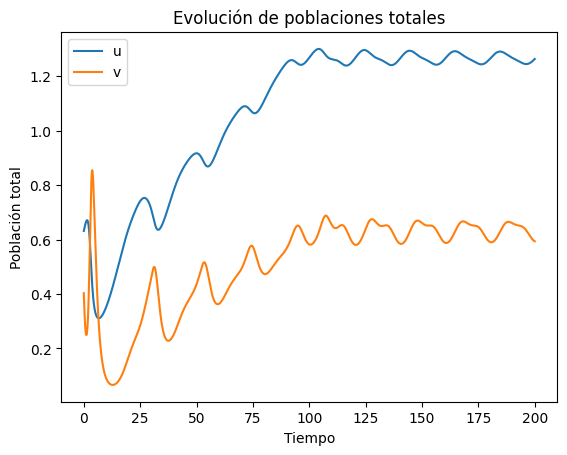

In [ ]:
u_t = np.sum(u_osc,axis=0)*dx
v_t = np.sum(v_osc,axis=0)*dx

plt.plot(t_osc,u_t,label='u')
plt.plot(t_osc,v_t,label='v')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Población total')
plt.title('Evolución de poblaciones totales')

Se observa un comportamiento periódico en las poblaciones de presas y depredadores, con oscilaciones que presentan un leve desfase entre ambas. Este patrón puede interpretarse cualitativamente de la siguiente manera:

Cuando la población de presas es alta, los depredadores aumentan su tasa de crecimiento. Sin embargo, este aumento en la población de depredadores genera un aumento en la tasa de mortalidad de presas. A medida que las presas escasean, los depredadores comienzan a disminuir, lo que permite que las presas se recuperen al haber menos presión de depredación. Este ciclo se repite, dando lugar a las oscilaciones observadas.

El grafico de arriba confirma el echo de que la poblacion total dado un tiempo ($t \sim 100$) llega a un estacionario en el que el sistema oscila periodicamente.

$\bf{b)} $ Integracion para diferentes $D_{1,2}$

In [ ]:
#@title integracion
D_osc = 0.1
d_osc = 5
B_osc = np.array([-c,d_osc])

dt_osc = 1e-3
step = 200000
nt = step
t_osc = np.arange(step)*dt_osc
tf_osc = t_osc[-1]

U = []
V = []

D_osc_values = [0.001,0.01,0.1, 0.5,1]

for d in D_osc_values:
    D = np.array([d, d])

    u_osc = np.zeros((nx, step))
    v_osc = np.zeros((nx, step))

    u_osc[:, 0] = 0.4 * gaussian(x, A_u, np.pi, sigma_u)
    v_osc[:, 0] = 0.2 * np.abs(np.sin(x))

    for i in tqdm(np.arange(step - 1)):
        # Pass u and v as a tuple to evol
        u_osc[:, i + 1], v_osc[:, i + 1] = evol((u_osc[:, i], v_osc[:, i]), K, A, B_osc, D, nx, dt_osc)

    U.append(u_osc)
    V.append(v_osc)

100%|██████████| 199999/199999 [00:38<00:00, 5231.53it/s]


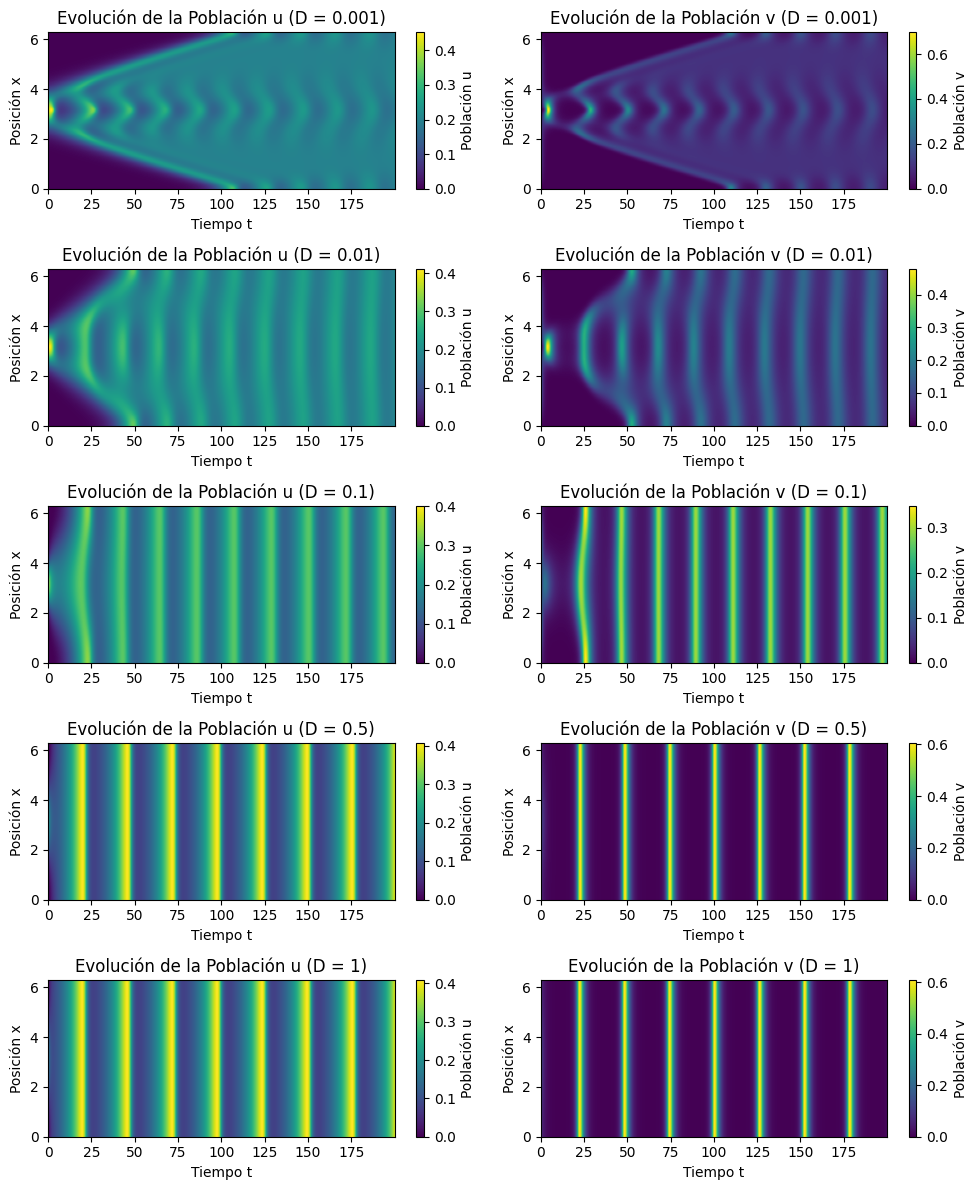

In [ ]:
#@title imshow

U_osc_values = U
V_osc_values = V

fig, ax = plt.subplots(5, 2, figsize=(10, 12))  # 3 rows, 2 columns

for i, D in enumerate(D_osc_values):
    # Plot for u
    im1 = ax[i, 0].imshow(U_osc_values[i], cmap='viridis', aspect='auto', extent=[0, tf_osc, 0, 2 * np.pi], origin='lower')
    fig.colorbar(im1, ax=ax[i, 0], label='Población u')
    ax[i, 0].set_title(f'Evolución de la Población u (D = {D})')
    ax[i, 0].set_ylabel('Posición x')
    ax[i, 0].set_xlabel('Tiempo t')

    # Plot for v
    im2 = ax[i, 1].imshow(V_osc_values[i], cmap='viridis', aspect='auto', extent=[0, tf_osc, 0, 2 * np.pi], origin='lower')
    fig.colorbar(im2, ax=ax[i, 1], label='Población v')
    ax[i, 1].set_title(f'Evolución de la Población v (D = {D})')
    ax[i, 1].set_ylabel('Posición x')
    ax[i, 1].set_xlabel('Tiempo t')

plt.tight_layout()
plt.show()


In [ ]:
for i, D in enumerate(D_osc_values):  # Skip the first element (D = 0.01)
    animacion((20/3, 4), U_osc_values[i].T, 'Evol. $u$', 'Posicion', '$u$', x, dt_osc, tf_osc, 12)
    animacion((20/3, 4), V_osc_values[i].T, 'Evol. $v$', 'Posicion', '$v$', x, dt_osc, tf_osc, 12)


Output hidden; open in https://colab.research.google.com to view.

Los coeficientes de difusión controlan, justamente, la tasa con  a la que las concentraciones de $u$ y $v$, se difunden. Por lo que para tasas menores, el efecto de difusión es menor, por lo que persisten mas. Y para tasas mayores se difunden mas rapido. Esto se ve claramente en las integraciones a medida que se aumenta el orden de magnitud de $D$.

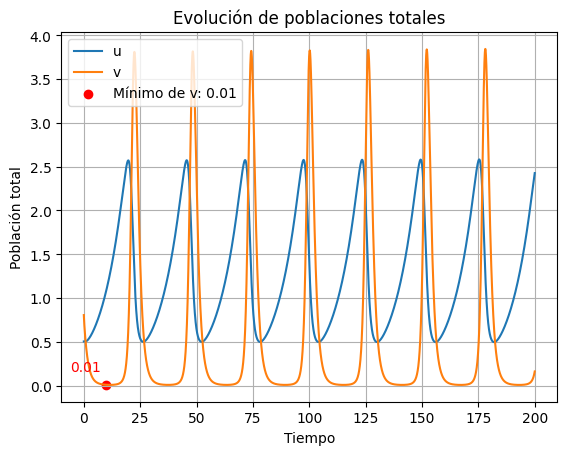

In [ ]:
u_t = np.sum(U[4],axis=0)*dx
v_t = np.sum(V[4],axis=0)*dx

plt.plot(t_osc, u_t, label='u')
plt.plot(t_osc, v_t, label='v')

min_v_t_idx = np.argmin(v_t)
min_v_t_time = t_osc[min_v_t_idx]
min_v_t_value = v_t[min_v_t_idx]

# Annotate the minimum on the plot
plt.scatter(10, min_v_t_value, color='red', label=f'Mínimo de v: {min_v_t_value:.2f}')
plt.annotate(f'{min_v_t_value:.2f}',
             (10, min_v_t_value),
             textcoords="offset points",
             xytext=(-15, 10),
             ha='center', color='red')

# Add labels, title, legend, and grid
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Población total')
plt.title('Evolución de poblaciones totales')
plt.grid()

# Display the plot
plt.show()

Se observa que para coeficientes de difusion muy altos, la solucion se acerca a 0 de tal forma que se plantea la duda sobre la validez de un modelado continuo en contextos donde las poblaciones son extremadamente bajas.

**Ejercicio 2: Modelo para la propagación del fuego, ecuación de Kuramoto-Sivashinsky**

---




La ecuación de Kuramoto-Sivashinsky viene dada por

$$ u_t = -u_{xx} -u_{xxxx} - (u_x)^2/2 $$

Derivando respecto a x y tomando $v = u_x$ se tiene

$$ v_t = -v_{xx} -v_{xxxx} - vv_x, $$

de donde puede verse que el término $v_{xx}$ representa la reacción, que $v_{xxxx}$ es el término de disipación y $vv_x$ es el término advectivo.


**a**) ¿Qué simetrías tiene esta ecuación? Basado en esto, y dado un dominio de longitud L y cdc periódicas elegí una base de Fourier y escribí una proyección de Galerkin de esta ecuación, hasta llegar a la expresión explícita para la evolución temporal del sistema.

**b**) Escribi explícitamente los primeros cuatro modos y estudiá la primera bifrucación del sistema (a dos modos). A partir de esto, ¿Qué esperás que pase al agregar mas modos?

**c**) Integrá la ecuación numéricamente con condiciones de contorno periódicas, utilizando un método numérico a elección. *Ayuda: Para trabajar con una variable $x \in [0,2\pi)$ y poder cambiar fácilmente la longitud total del recinto a *$2\pi L$, *redefini* $x'=x/L$ y $t'=t/L^2$. *La ecuación que se obtiene entonces es*

$$ u_{t'} = -u_{x'x'} -u_{x'x'x'x'}/L^2 - (u_{x'})^2/2 $$

Qué pasa si se extiende el dominio espacial a $n\pi$ (probá con distintos L)? Explicá detalladamente la dinámica que ves en relación al item previo (Ayuda: usa gráficos 2D de la solución obtenida). Es posible caracterizar las soluciones con unos pocos modos?

Para las $u(x,t)$ obtenidas numéricamente, puede resultar de mucha utilidad trabajar con la función de estructura de orden 2 de la velocidad, dada por

$$ S_2(l,t) = < [u(x+l,t)-u(x,t)]^2 > = <\delta u_l^2>  $$

la cual tiene un vínculo directo con el espectro de Energía  en el espacio de Fourier $E(k)$ ($S_2$ es la "energía en el espacio real"). De esta forma, ya sea con $E(k)$ o $S_2$, es posible argumentar acerca de la dinámica del sistema en términos de la cantidad de modos que estan excitados en la proyección de Galerkin, y de cual es su amplitud. Pero mas aún, en sistemas autosimilares, es posible hallar la dimension fractal del sistema. Si además el sistema es monofractal, toda la estadistica del sistema queda unívocamente determinada por $S_2$.^

**d**) Calculá la función de estructura $S_2(l)$ y el espectro de energía $E(k)$, para distintos tiempos. Graficá promedios de $S_2(l)$ y $E(k)$ en el estado estacionario. Justificá.

**e**)A partir de estos, hallá un rango de autosimilaridad para el cual puedan escribirse leyes de scala de la forma $E(k)\sim k^{\alpha}$ y $S_2(l)\sim l^{\beta}$. De acuerdo entonces a las soluciones numéricas, cuánto valen $\alpha$ y $\beta$? Qúe relación guardan entre si? Es lo esperado?

**f**) Opcional: Hallá la dimensión fractal, D, del sistema. Argumentá. El valor obenido refleja las estructuras que ves en los gráficos de $u(x,t)$?










---
$ \bf{Respuestas}$

$ \bf{a)}$
La ecuación de Kuramoto-Sivashinsky viene dada por

$$ u_t = -u_{xx} -u_{xxxx} - (u_x)^2/2 (1)$$

Derivando respecto a x y tomando $v = u_x$ se tiene

$$ v_t = -v_{xx} -v_{xxxx} - vv_x, $$

de donde puede verse que el término $v_{xx}$ representa la reacción, que $v_{xxxx}$ es el término de disipación y $vv_x$ es el término advectivo.

Las simetrías que presenta esta ecuación son de traslación en $u$ y $x$: $u=u+ \beta, x=x+ \alpha$ (invarianza de galileo)   y de reflexión en $x$: $x=-x$.

Al tener estas simetrías la descomposición óptima es con Fourier:

$u(x,t)=\sum a_k(t)\phi_k(x); \phi_k(x)=e^{\frac{i2 \pi kx}{L}}$

Donde por ser $u(x,t)$ real $a_k^{*}(t)=a_{-k}(t)$ y $∫_{0}^{L}e^{\frac{i2 \pi (k-l)x}{L}}dx=L \delta_{kl}$

Calculamos los términos de (1)

$\partial_x \phi_k=i \frac{2 \pi k }{L} \phi_k$;

$\partial_{xx} \phi_k=-(\frac{2 \pi k }{L})^2 \phi_k$;

 $\partial_{xxxx} \phi_k=(\frac{2 \pi k }{L})^4 \phi_k$

Reemplazamos

$$\sum_k[\dot a_k \phi_k - (\frac{2 \pi k }{L})^2 a_k\phi_k + (\frac{2 \pi k }{L})^4 a_k \phi_k] + \frac{1}{2}[\sum_k i \frac{2 \pi k }{L} a_j \phi_k][\sum_j i \frac{2 \pi j }{L} a_j \phi_j] = 0$$

Integramos ambos lados $∫_{0}^{L}\phi_{-l}dx$ y usamos la propiedad $∫_{0}^{L}\phi_{k}\phi_{-l}dx=∫_{0}^{L}e^{\frac{i2 \pi (k-l)x}{L}}dx=L \delta_{kl}$, luego

$$\Rightarrow \sum_k[\dot a_k\delta_{kl} -(\frac{2 \pi k }{L})^2 a_k \delta_{kl} +(\frac{2 \pi k }{L})^4 a_k\delta_{kl}]L + \frac{1}{2}[\sum_{k,l}(i\frac{2 \pi k}{L}) a_k (i\frac{2 \pi j}{L})a_j]L \delta_{k+j,l} =0$$

$$\Rightarrow \sum_k\dot a_l -(\frac{2 \pi l }{L})^2 a_l  + (\frac{2 \pi k }{L})^4 a_l - \frac{1}{2}(\frac{2 \pi}{L})^2 \sum_{j}j(l-j) a_j a_{l-j} =0$$

Reescalando el tiempo $t'=(\frac{2 \pi}{L})^2 t$

$$\dot a_l= l^2 [1-(\frac{2 \pi l}{L})^2]a_l - \frac{1}{2} \sum_j j(l-j) a_j a_{l-j}$$



**b**) Escribi explícitamente los primeros cuatro modos y estudiá la primera bifrucación del sistema (a dos modos). A partir de esto, ¿Qué esperás que pase al agregar mas modos?

$\dot a_1=  [1-(\frac{2 \pi}{L})^2]a_1  +  \frac{1}{2}( (2)(-1)a_2a_{1-2} +(3)(-2)a_3a_{1-3}+(4)(-3)a_4a_{1-4}) =[1-(\frac{2 \pi}{L})^2]a_1 +\frac{1}{2}(4a_2a_{-1} -6a_3a_{-2} -12a_4a_{-3}) =[1-(\frac{2 \pi}{L})^2]a_1 + \frac{1}{2}(-4a_{1}^*a_2 - 6a_{2}^*a_3  - 12a_{3}^*a_4 )$

$\dot a_2= 2^2 [1-(\frac{2 \pi 2}{L})^2]a_2 + \frac{1}{2}((1)a_1a_{2-1}+ 0 -3a_3a_{1-3}+4(-2)a_4a_{1-4})= 4[1-(\frac{4\pi}{L})^2]a_2 + \frac{1}{2}(a_1^2 - 3a_{2}^*a_3 - 8a_{3}^*a_4)$

$\dot a_3= 9[1-(\frac{6 \pi }{L})^2]a_3 + \frac{1}{2}(2a_1a_{2}+ 2a_2a_{1} -4a_1^*a_{4})=9[1-(\frac{6 \pi }{L})^2]a_3 + \frac{1}{2}(4a_1a_{2}-4a_1^*a_{4})$

$\dot a_4= 16[1-(\frac{8 \pi }{L})^2]a_4 + \frac{1}{2}(3a_1a_{3}+ 4a_2a_{2} +3a_3a_1)=16[1-(\frac{8 \pi }{L})^2]a_4 + \frac{1}{2}( 4a_2^2 +6a_3a_{1}) $

Los $a_j$ son coeficientes complejos por lo que tenemos dos ecuaciones en cada $\dot a_j$.

Para buscar bifurcaciones: miramos los puntos fijos, linealizamos y vemos que sucede ante perturbaciones.

La condición de punto fijo es u=0 o $a_l=0$ para todo l.

Linealizamos cerca del punto fijo, para $\dot a_l$ significa eliminar el término de acople
$$\dot a_l= l^2 [1-(\frac{2 \pi l}{L})^2]a_l - \frac{1}{2} \sum_j j(l-j) a_j a_{l-j} $$ $$\rightarrow \dot a_l= l^2 [1-(\frac{2 \pi l}{L})^2]a_l$$

A partir de esto, si $\lambda_l=1-(\frac{2 \pi l}{L})^2< 0 \Rightarrow L< 2\pi l\rightarrow estable$

$ \lambda_l=1-(\frac{2 \pi l}{L})^2> 0 \Rightarrow L> 2\pi l\rightarrow inestable$

A partir de esto podríamos ver que truncando a dos modos tenemos una bifurcación tipo pitchfork. Al sumar mas modos tendremos bifurcaciones globales propias de un sistema caótico.

Si truncamos a dos modos tenemos

$\dot a_1=[1-(\frac{2 \pi}{L})^2]a_1 - 2a_{1}^*a_2 $

$\dot a_2=[1-(\frac{4 \pi}{L})^2]a_2 - \frac{a_1^2}{2}$

Recordando que son complejos

$\dot a_1=\lambda_1 a_1 - 2a_{1}^*a_2 $

$\dot a_1^*=\lambda_1 a_1^* - 2a_{1}a_2^* $

$\dot a_2=\lambda_1 a_2 - \frac{a_1^2}{2}$

$\dot a_2^*=\lambda_1 a_2^* - \frac{a_1^{*2}}{2}$

Entonces, planteamos la condición de punto fijo

$\dot a_2=0 \Rightarrow a_2=\frac{a_1^2}{2 \lambda2}$ y $a_2^*=\frac{a_1^{*2}}{2 \lambda2}$

Reemplazando en $\dot a_1$ e igualando a cero

$a_1(\lambda_1-abs(a_1)^2/abs(\lambda_2))=0$ y $a_1^*(\lambda_1-abs(a_1)^2/abs(\lambda_2))=0$

Tenemos por puntos fijos:

$a_1=a_1^*=a_2=a_2^*=0$ y $a_1=\sqrt{ \lambda_1abs( \lambda_2)}$

Se ve que el parametro de control es  $L$. Asi viendo las ecuacion diferenciales de los 2 primeros modos, se marca una bifurcacion en $L = 2\pi$.

$ \bf{c)}$ $ u_{t'} = -u_{x'x'} -u_{x'x'x'x'}/L^2 - (u_{x'})^2/2 $


In [ ]:
#@title Librerias
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from tqdm import tqdm
from IPython.display import Image

In [ ]:
#@title Evol
def evol(u,k,L,nx,dt):
    f = np.fft.rfft(u)
    ft = f
    for ord in [2,1]:
        D = dt/ord
        fnl = compute_NL(f,k,nx)
        f = ft + D * (k**2 * f - k**4 * f/(L**2) - fnl)
        f[int(nx/3):] = 0
    return np.fft.irfft(f)

def compute_NL(f,k,nx):
    fx  = 1j*k*f
    vx  = np.fft.irfft(fx)
    v = vx*vx/2
    out = np.fft.rfft(v)
    return out

In [ ]:
#@title Evol C)
n = 30

L = n * np.pi

step = 20000
nt = step
dt = 1e-5
nx = 512

k = np.arange(0,nx/2+1)
t = np.arange(step)*dt
x = np.linspace(0,2*np.pi,nx,endpoint=False)

tf = t[-1]
u = np.zeros([nx, step])
u[:, 0] = np.sin(x)

for i in tqdm(np.arange(step-1)):
    u[:, i+1] = evol(u[:, i],k,L,nx,dt)

100%|██████████| 19999/19999 [00:03<00:00, 5556.33it/s]


Text(0.5, 0, 'Tiempo t')

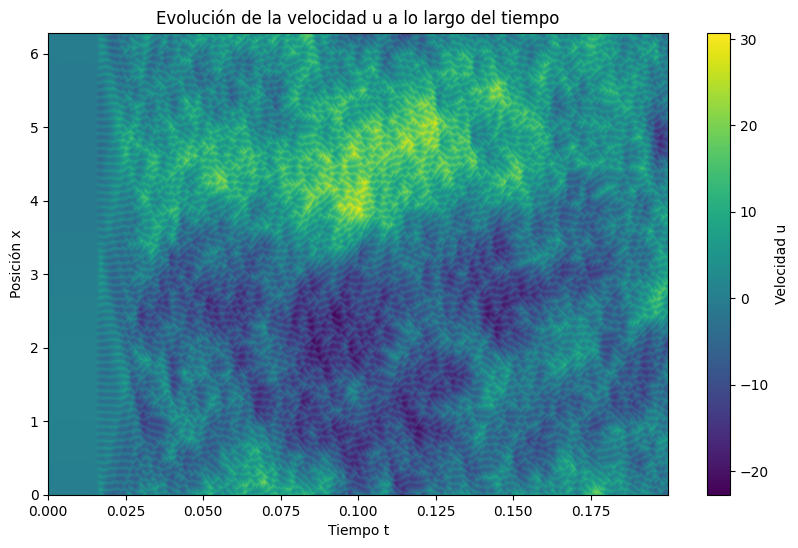

In [ ]:
#@title Imshow
fig, ax = plt.subplots( figsize=(10, 6))  # 1 row, 2 columns
u_subs = u - np.mean(u, axis=0)
im1 = ax.imshow(u_subs, cmap='viridis', aspect='auto', extent=[0, tf, 0, 2 * np.pi], origin='lower')
fig.colorbar(im1, ax=ax, label='Velocidad u')
ax.set_title('Evolución de la velocidad u a lo largo del tiempo')
ax.set_ylabel('Posición x')
ax.set_xlabel('Tiempo t')

#Restar a cada tiempo el valor medio.

Processing L = 34π: 100%|██████████| 19999/19999 [00:03<00:00, 6594.08it/s]


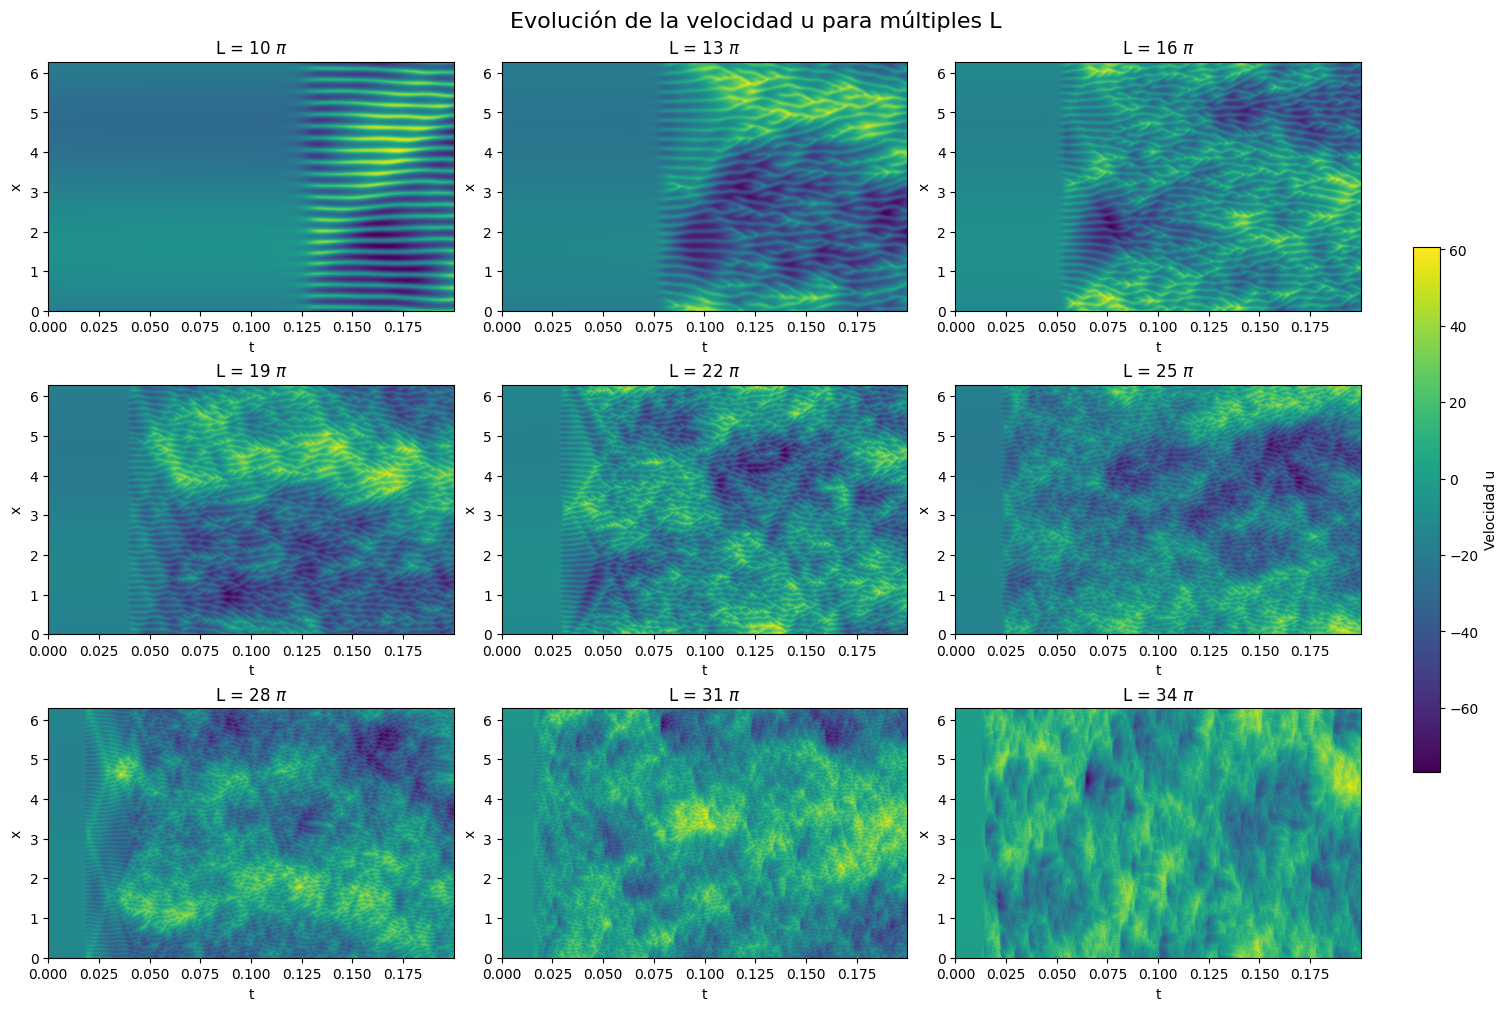

In [ ]:
#@title Evolucion de u para distintos L
step2 = 20000  # Primer set
dt2 = 1e-5
nx2 = 512

step1 = 200000  # Segundo set
dt1 = 1e-6
nx1 = 512

number_L = np.arange(10, 37, 3)
num_plots = len(number_L)
rows = int(np.ceil(np.sqrt(num_plots)))
cols = int(np.ceil(num_plots / rows))

fig, axes = plt.subplots(rows, cols, figsize=(15, 10), constrained_layout=True)
axes = axes.flatten()  # Flatten grid pq4q low  1D array

for idx, n in enumerate(number_L):
    if n < 19:
        step, dt, nx = step1, dt1, nx1
    else:
        step, dt, nx = step2, dt2, nx2

    t = np.arange(step) * dt
    tf = t[-1]
    x = np.linspace(0, 2 * np.pi, nx, endpoint=False)
    k = np.arange(0, nx / 2 + 1)

    L = n * np.pi
    u = np.zeros([nx, step])
    u[:, 0] = np.sin(x)

    for i in tqdm(np.arange(step - 1), desc=f"Processing L = {n}π"):
        u[:, i + 1] = evol(u[:, i], k, L, nx, dt)

    u_subs = u - np.mean(u, axis=0)

    im = axes[idx].imshow(
        u_subs, cmap='viridis', aspect='auto',
        extent=[0, tf, 0, 2 * np.pi], origin='lower'
    )
    axes[idx].set_title(fr"L = {n} $\pi$")
    axes[idx].set_ylabel('x')
    axes[idx].set_xlabel('t')

# Hide unused subplots
for ax in axes[len(number_L):]:
    ax.axis('off')

# Shared colorbar
cbar = fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Velocidad u')

plt.suptitle('Evolución de la velocidad u para múltiples L', fontsize=16)
plt.show()

A las soluciones obtenidas se les resto el valor medio para cada tiempo, ya que el modo 0 esta desacoplado de los otros modos, generando en nuestro caso un decaimiento monotono.

Se observa que a medida que aumenta $L$ en $n\pi$ se van activando mas modos, llegando un punto en el que se generan bifurcaciones globales, esto se observa en las integraciones en el hecho de que para mayores $n\pi$ el sistema se vuelve cada vez complejo.

In [ ]:
#@title Animacion
animacion((20/3,4), u_subs.T, 'Evol. $u$','Posicion','$u$',x,dt,tf,6)

Output hidden; open in https://colab.research.google.com to view.

**d**) Calculá la función de estructura $S_2(l)$ y el espectro de energía $E(k)$, para distintos tiempos. Graficá promedios de $S_2(l)$ y $E(k)$ en el estado estacionario. Justificá.

In [ ]:
#@title Evol d)
n = 30

L = n * np.pi

step = 20000
nt = step
dt = 1e-5
nx = 512

k = np.arange(0,nx/2+1)
t = np.arange(step)*dt
x = np.linspace(0,2*np.pi,nx,endpoint=False)

tf = t[-1]
u_d = np.zeros([nx, step])
u_d[:, 0] = np.sin(x)

for i in tqdm(np.arange(step-1)):
    u_d[:, i+1] = evol(u_d[:, i],k,L,nx,dt)
u_d = u_d - np.mean(u_d, axis=0)

100%|██████████| 19999/19999 [00:03<00:00, 6546.74it/s]


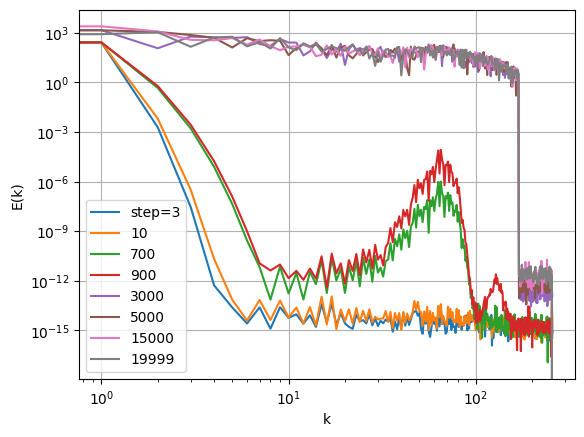

In [ ]:
#@title Espectro de energía para distintos tiempos

#primeros tiempos
u_d_i=u_d[:,1]
u_d_2=u_d[:,2]
u_d_3=u_d[:,3]

u_d_10=u_d[:,10]
u_d_20=u_d[:,20]
u_d_30=u_d[:,30]

u_d_300=u_d[:,300]
u_d_500=u_d[:,500]
u_d_700=u_d[:,700]
u_d_900=u_d[:,900]

#intermedios
u_d_3000=u_d[:,3000]
u_d_5000=u_d[:,5000]
u_d_7000=u_d[:,7000]

#últimos
u_d_10000=u_d[:,10000]
u_d_12000=u_d[:,12000]
u_d_15000=u_d[:,15000]
u_d_17000=u_d[:,17000]
u_d_f=u_d[:,-1]

E_1=np.abs(np.fft.rfft(u_d_i))
E_2=np.abs(np.fft.rfft(u_d_2))
E_3=np.abs(np.fft.rfft(u_d_3))



E_10=np.abs(np.fft.rfft(u_d_10))
E_20=np.abs(np.fft.rfft(u_d_20))
E_30=np.abs(np.fft.rfft(u_d_30))



E_700=np.abs(np.fft.rfft(u_d_700))
E_900=np.abs(np.fft.rfft(u_d_900))
E_3000=np.abs(np.fft.rfft(u_d_3000))
E_5000=np.abs(np.fft.rfft(u_d_5000))
E_7000=np.abs(np.fft.rfft(u_d_7000))
E_10000=np.abs(np.fft.rfft(u_d_10000))
E_12000=np.abs(np.fft.rfft(u_d_12000))
E_15000=np.abs(np.fft.rfft(u_d_15000))
E_17000=np.abs(np.fft.rfft(u_d_17000))
E_f=np.abs(np.fft.rfft(u_d_f))

plt.loglog(k,E_3,label='step=3')
plt.loglog(k,E_10,label='10')
plt.loglog(k,E_700,label='700')
plt.loglog(k,E_900,label='900')
plt.loglog(k,E_3000,label='3000')
plt.loglog(k,E_5000,label='5000')
plt.loglog(k,E_15000,label='15000')
plt.loglog(k,E_f,label='19999')
plt.xlabel('k')
plt.ylabel('E(k)')
plt.grid()
plt.legend()
plt.show()

Observamos el espectro para varios tiempos, podemos ver que se dividen en tres grupos distintos, siendo los superiores los correspondientes al estacionario.

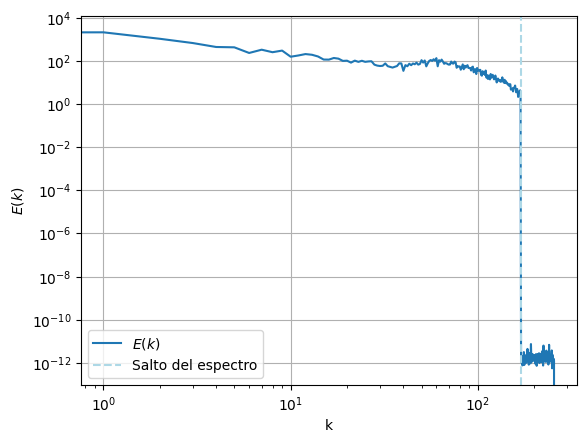

In [ ]:
#@title Espectro promedio en el estacionario
es= [E_5000,E_7000,E_10000,E_12000,E_15000,E_17000,E_f]
times = [5000, 12000, 15000, 'f']
E_prom = np.mean(es, axis=0)

# Graficar S2_prom

plt.loglog(k,E_prom,label=r"$E(k)$")

plt.axvline(169,c='lightblue',linestyle='--',label='Salto del espectro')
plt.xlabel("k")
plt.ylabel(r"$E(k)$")
plt.legend()
plt.grid()
plt.show()

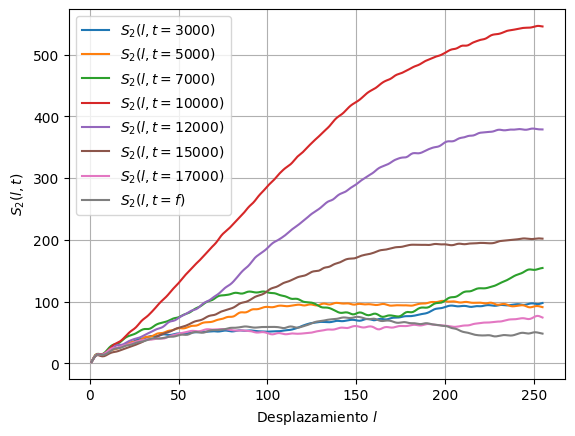

In [ ]:
#@title Función de estructura para distintos tiempos

# Lista de velocidades (ejemplo de datos)
u = u_d_f

L = len(u)
l_values = np.arange(1, L // 2)  #solo tomamos la mitad porque es periódico

us= [u_d_3000,u_d_5000,u_d_7000,u_d_10000,u_d_12000,u_d_15000,u_d_17000,u_d_f]
times = [3000,5000,7000,10000, 12000, 15000,17000, 'f']
s = []

# Calcular y graficar S2 para cada u
for u, time in zip(us, times):
    S2 = []
    for l in l_values:
        delta_u_l = u[(np.arange(L) + l) % L] - u
        S2.append(np.mean(delta_u_l**2))

    S2 = np.array(S2)
    s.append(S2)

    # Incluimos el tiempo en el label de la gráfica
    plt.plot(l_values, S2, label=f"$S_2(l, t={time})$")

# Etiquetas y formato de la gráfica
plt.xlabel("Desplazamiento $l$")
plt.ylabel(r"$S_2(l, t)$")
plt.legend()
plt.grid()
plt.show()


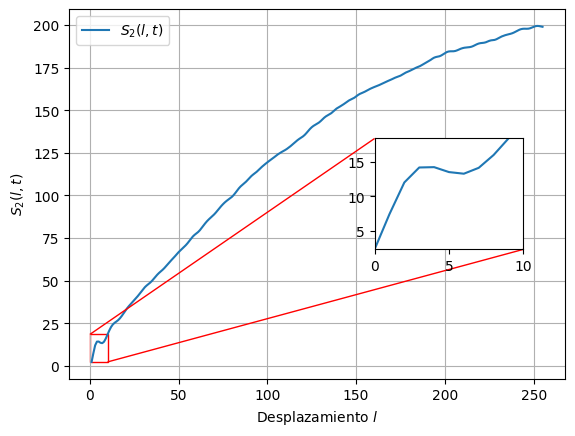

In [ ]:
#@title Función de estructura promedio en el estacionario

import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

# Suponiendo que ya tienes S2_prom calculado
S2_prom = np.mean(s, axis=0)

# Graficar S2_prom
fig, ax = plt.subplots()

ax.plot(l_values,S2_prom, label=r"$S_2(l, t)$")
ax.set_xlabel("Desplazamiento $l$")
ax.set_ylabel(r"$S_2(l, t)$")
ax.legend()
ax.grid()

# Crear el recuadro de zoom
axins = inset_axes(ax, width="30%", height="30%", loc="right", borderpad=3)

# Graficar la misma curva en el recuadro de zoom
axins.plot(S2_prom, label=r"$S_2(l, t)$")
axins.set_xlim(0, 10)
axins.set_ylim(np.min(S2_prom[0:10]), np.max(S2_prom[0:10]))

# Marcar el área de zoom en el gráfico original
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="r")

plt.show()


Podemos ver como el promedio de $S_2$ aumenta junto con l, lo que nos habla de una disminución de la correlación a medida que nos alejamos en el espacio. La tendencia se detiene alrededor de l=200 donde se vuelve constante, esto se relaciona con el hecho de que el sistema presenta una distribución homogénea de las fluctuaciones a escalas grandes. Desde este punto la correlación es baja pero presenta pocas variaciones. El sistema es autosimilar a dichas escalas.

curiosidad: En el recuadro podemos observar una pequeña región del espacio para l aprox 5, en que S2 viene creciendo y luego entra en un pequeño valle para volver a crecer. ¿Estamos viendo otra escala en la que el sistema presenta autosimilitud?

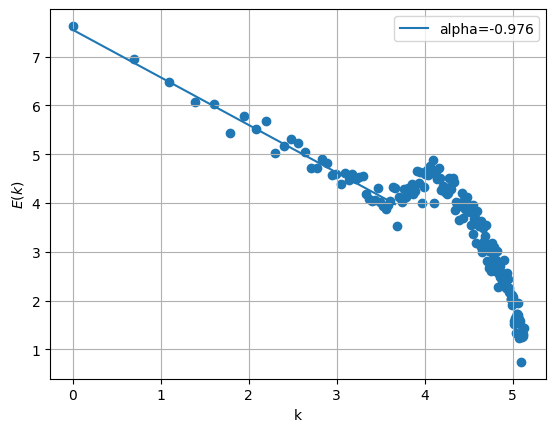

In [ ]:
#@title Ley de potencia para E_prom

logBb = np.log(E_prom[1:40] )
logAa = np.log(k[1:40] )

logB = np.log(E_prom[1:169] )
logA = np.log(k[1:169] )
m, c = np.polyfit(logAa, logBb, 1,cov=True)
m0_e=m[0]
m1_e=m[1]
plt.scatter(logA,logB)
plt.plot(logAa,m0_e*logAa+m1_e,label=f'alpha={m0_e:.3f}')
plt.xlabel("k")
plt.ylabel(r"$E(k)$")
plt.legend()
plt.grid()
plt.show()


La ley de potencia encontrada $E\sim k^{-0.976}$ si bien no se encuentra en el rango esperado es cercana a este: $E\sim k^{\alpha}$ con $\alpha=-n$ y $1<n<3$

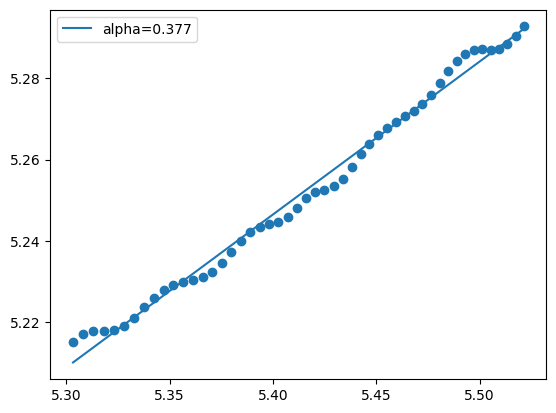

In [ ]:
#@title Ley de potencia para S2_prom

logA = np.log(l_values[200:250])
logB = np.log(S2_prom[200:250])
m, c = np.polyfit(logA, logB, 1,cov=True)
m0=m[0]
m1=m[1]
plt.scatter(logA,logB)
plt.plot(logA,m0*logA+m1,label=f'alpha={m0:.3f}')
plt.legend()
plt.show()

Para $S_2$ esperábamos una ley $S_2\sim l^\beta  $ con $\beta = n-1$. En este caso llegamos a $S_2=l^{0.37}$, siendo la relación $0.976-1=-0.024<\beta$ un orden de magnitud por debajo de lo esperada.